In [83]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

In [84]:
name = 'Brightness_set_3_randombrightnessnone_2024_12_14_03_41_26'
file = os.path.join(name, name + '.json')

# Load JSON data

In [85]:
# Load JSON data
with open(file, 'r') as f:
    data = json.load(f)

In [86]:
# Inspect a single client's data
#print(data)
# print("Inspecting a single client's data...")
# print(data["client_results"]["1"]["0"])  # Adjust key names as needed

# Extract client metrics

In [87]:
def extract_client_metrics(data):
    client_metrics = {}
    for round_number, clients in data["client_results"].items():
        for client_id, client_data in clients.items():
            if client_id not in client_metrics:
                client_metrics[client_id] = []
            # Extract metrics for each round
            client_metrics[client_id].append({
                "round": int(round_number),
                "accuracy": client_data.get("accuracy", 0),
                "precision": client_data.get("precision", 0),
                "recall": client_data.get("recall", 0),
                "f1_score": client_data.get("f1_score", 0),
                "loss": client_data.get("loss", 0)
            })
    
    # Sort metrics by round for each client
    for client_id in client_metrics:
        client_metrics[client_id].sort(key=lambda x: x["round"])
    
    return client_metrics

client_metrics = extract_client_metrics(data)

In [88]:
# Check extracted metrics
print("Extracted client metrics (first client):")
for client_id, metrics in client_metrics.items():
    print(f"Client {client_id}: {metrics}")
    break

Extracted client metrics (first client):
Client 0: [{'round': 1, 'accuracy': 0.4640692640692641, 'precision': 0.6443034067381893, 'recall': 0.4640692640692641, 'f1_score': 0.2986157122942938, 'loss': 0.7884121757664092}, {'round': 2, 'accuracy': 0.6441558441558441, 'precision': 0.6659604738387997, 'recall': 0.6441558441558441, 'f1_score': 0.640396601336584, 'loss': 1.1431630143564042}, {'round': 3, 'accuracy': 0.6458874458874458, 'precision': 0.6673643828169215, 'recall': 0.6458874458874458, 'f1_score': 0.6422813058015017, 'loss': 1.8474991359326938}, {'round': 4, 'accuracy': 0.6493506493506493, 'precision': 0.671509200334034, 'recall': 0.6493506493506493, 'f1_score': 0.6456462859886049, 'loss': 1.725402865201643}, {'round': 5, 'accuracy': 0.6406926406926406, 'precision': 0.6451905524989304, 'recall': 0.6406926406926406, 'f1_score': 0.6411529452960072, 'loss': 1.3284073882315257}, {'round': 6, 'accuracy': 0.6432900432900432, 'precision': 0.6491802721423087, 'recall': 0.6432900432900432

# 1. Calculate Variance of Accuracy

In [89]:
# 1. Calculate Variance of Accuracy
def calculate_accuracy_variance(client_metrics):
    last_round_accuracies = [
        metrics[-1]["accuracy"] for metrics in client_metrics.values() if metrics
    ]
    return np.var(last_round_accuracies)

In [90]:
accuracy_variance = calculate_accuracy_variance(client_metrics)
print(f"Accuracy Variance: {accuracy_variance}")

Accuracy Variance: 0.00013570960064466516


# 2. Calculate Gini Coefficient

In [91]:
# 2. Calculate Gini Coefficient
def calculate_gini_coefficient(client_metrics):
    last_round_accuracies = sorted(
        [metrics[-1]["accuracy"] for metrics in client_metrics.values() if metrics]
    )
    n = len(last_round_accuracies)
    cumulative_accuracies = np.cumsum(last_round_accuracies)
    gini = (n + 1 - 2 * np.sum(cumulative_accuracies) / cumulative_accuracies[-1]) / n
    return gini

In [92]:
gini_coefficient = calculate_gini_coefficient(client_metrics)
print(f"Gini Coefficient: {gini_coefficient}")

Gini Coefficient: 0.009939260077305256


# 3. Calculate Recall Variance

In [93]:
# 3. Calculate Recall Variance
def calculate_recall_variance(client_metrics):
    last_round_recalls = [
        metrics[-1]["recall"] for metrics in client_metrics.values() if metrics
    ]
    return np.var(last_round_recalls)


In [94]:
recall_variance = calculate_recall_variance(client_metrics)
print(f"Recall Variance: {recall_variance}")

Recall Variance: 0.00013570960064466516


# 4. Visualize Accuracy over Rounds for Each Client

In [95]:
# 4. Visualize Accuracy over Rounds for Each Client
def plot_client_accuracies(client_metrics):
    for client_id, metrics in client_metrics.items():
        if metrics:  # Skip empty metrics
            rounds = [entry["round"] for entry in metrics]
            accuracies = [entry["accuracy"] for entry in metrics]
            plt.plot(rounds, accuracies, label=f'Client {client_id}')
    
    plt.xlabel('Rounds')
    plt.ylabel('Accuracy')
    plt.title('Client Accuracy over Rounds')
    plt.legend()
    plt.show()

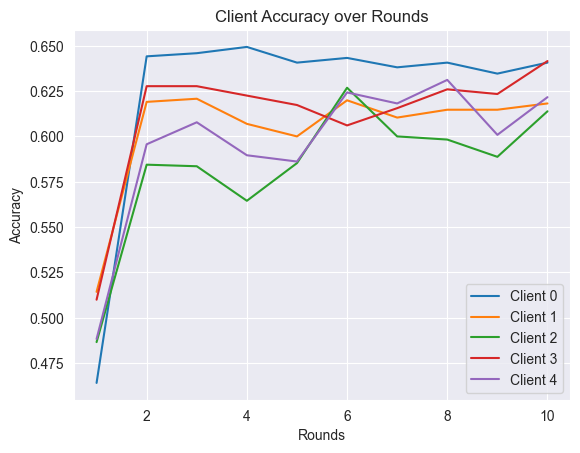

In [96]:
plot_client_accuracies(client_metrics)

# 5. Fairness Improvement Example: Reweighting Clients

In [97]:
# 5. Fairness Improvement Example: Reweighting Clients
def reweight_clients(client_metrics):
    last_round_accuracies = {
        client_id: metrics[-1]["accuracy"] for client_id, metrics in client_metrics.items() if metrics
    }
    total_accuracy = sum(last_round_accuracies.values())
    weights = {client_id: acc / total_accuracy for client_id, acc in last_round_accuracies.items()}
    return weights

client_weights = reweight_clients(client_metrics)
print(f"Client Weights: {client_weights}")

Client Weights: {'0': 0.20430701270016563, '1': 0.19712865819988956, '2': 0.19574820541137494, '3': 0.20458310325786858, '4': 0.19823302043070126}


In [98]:
# Optional: Save the results
fairness_results = {
    "accuracy_variance": accuracy_variance,
    "gini_coefficient": gini_coefficient,
    "recall_variance": recall_variance,
    "client_weights": client_weights
}
result_path = os.path.join(name, "fairness_results.json")
with open(result_path, 'w') as f:
    json.dump(fairness_results, f, indent=4)

print("Fairness results saved to fairness_results.json")

Fairness results saved to fairness_results.json
